In [1]:
library(readxl)
library(plyr)
library(ggplot2)
library(repr)
library(ez)
library(reshape2)
library(stringr)

# 0. Data imports

I'm working directly from Excel format. Variables below specify urls etc.

The 'Questions' tab contains all questions asked to each group of participants; we can map questions by row number to their corresponding columnns for legends etc. This tab also contains a variable name for long questions.

In [2]:
filename <- 'AllResponses.xlsx'

#Load the responses
questions <- read_excel(filename, sheet = "Questions")
fics <- read_excel(filename, sheet = "FICS")
academics_en <- read_excel(filename, sheet = "Academic EN")
academics_mt <- read_excel(filename, sheet = "Academic MT")
nonacademics_en <- read_excel(filename, sheet = "NonAcademic EN")
nonacademics_mt <- read_excel(filename, sheet = "NonAcademic MT")
students_en <- read_excel(filename, sheet = "Student EN")
students_mt <- read_excel(filename, sheet = "Student MT")

# 1. Data prep

Data is preprocessed as follows:


1. Additional variables introduced to indicate group (student/academic/non-academic) and langauge of response

In [3]:
academics_en <- data.frame(Role='AC', QLang='EN', academics_en)
academics_mt <- data.frame(Role='AC', QLang='MT', academics_mt)

nonacademics_en <- data.frame(Role='NAC', QLang='EN', nonacademics_en)
nonacademics_mt <- data.frame(Role='NAC', QLang='MT', nonacademics_mt)

students_en <- data.frame(Role='ST', QLang='EN', students_en)
students_mt <- data.frame(Role='ST', QLang='MT', students_mt)

2. Rename the first 157 variables (which are common to all DFs), ie those up to section 6.7 inclusive. Note that these include the new Role and Lang Variables.

In [4]:
#All variable names of common DFs
var_names <- c(c('Role', 'Lang'), questions$VariableName[1:155])

names(nonacademics_en) <- c(var_names, colnames(nonacademics_en)[158:length(colnames(nonacademics_en))])
names(nonacademics_mt) <- c(var_names, colnames(nonacademics_mt)[158:length(colnames(nonacademics_mt))])

names(students_en)  <- c(var_names, colnames(students_en)[158:length(colnames(students_en))])
names(students_mt)  <- c(var_names, colnames(students_mt)[158:length(colnames(students_mt))])

names(academics_en) <- c(var_names, colnames(academics_en)[158:length(colnames(academics_en))])
names(academics_mt) <- c(var_names, colnames(academics_mt)[158:length(colnames(academics_mt))])


3. merge all questions up to Section 6.7 (inclusive) into one DF, as these are common to all. Note that this corresponds to columns 3 to 157 for all DFs (after insertion of role and lang info)

In [9]:
#Common is a new DF, containing all responses from all categories, up to Section 6.7 inclusive
common <- rbind(academics_en[,1:157], 
                academics_mt[,1:157], 
                nonacademics_en[,1:157], 
                nonacademics_mt[,1:157], 
                students_en[,1:157], 
                students_mt[,1:157])

4. Add an "ID" variable, which is just a dummy for subject ID (useful later as the error/variance term in ANOVAs etc)

In [12]:
#Each row is a participant: Id is just an integer, but represented as factor
ID <- as.factor(rep(1:nrow(common)))

#IDs are just numbers, represented as factors
common <- cbind(ID, common)

4. For all datasets, Section 5 responses in MT have an inverted scale (1=agree) compared to EN (1=disagree). The MT ones are transformed to conform to the EN scale. This is done by subtracting the result from 6 (so 5 becomes 1, etc).

In [14]:
sec5_vars <- c("ComfortMT", "ComfortEN", "ComfortAR", "ComfortIT", "ComfortFR", "ComfortDE", "ComfortES", "ComfortOTHER", "CultureMT", "CultureEN", "CultureAR", "CultureIT", "CultureFR", "CultureDE", "CultureES", "CultureMULTILING", "CultureOTHER", "ProficiencyAimMT", "ProficiencyAimEN", "ProficiencyAimAR", "ProficiencyAimIT", "ProficiencyAimFR", "ProficiencyAimDE", "ProficiencyAimES", "ProficiencyAimOTHER")

for (v in sec5_vars) {
    common[common$Lang=='MT',][,v] <- 6 - common[common$Lang=='MT',][,v]
}

5. We map all FICS names to acronyms

In [15]:
common[common$Lang=='MT',]$FICS <- mapvalues(common[common$Lang=='MT',]$FICS, 
          from=fics$MT, 
          to=fics$ACRONYM)

common[common$Lang=='EN',]$FICS <- mapvalues(common[common$Lang=='EN',]$FICS, 
          from=fics$EN, 
          to=fics$ACRONYM)

The following `from` values were not present in `x`: L-Istitut għat-Teknoloġiji Aerospazjali, L-Istitut għall-Istudji Anglo-Taljani, L-Istitut Internazzjonali għall-Istudji fil-Barokk, L-Istitut għall-Bidla fil-Klima u l-Iżvilupp Sostenibbli, L-Istitut Konfuċju, L-Istitut tal-Logħob Diġitali, L-Istitut Edward de Bono għat-Tifsil u l-Iżvilupp tal-Ħsieb, L-Istitut tal-Gżejjer u l-Istati Żgħar, L-Istitut tal-Edukazzjoni Fiżika u l-Isport, L-Istitut għax-Xjenzi Spazjali u l-Astronomija, Iċ-Ċentru għaċ-Ċibernetika Bijomedika, Iċ-Ċentru tal-Profiċjenza fil-Lingwa Ingliża, Iċ-Ċentru Ewro-Mediterranju għar-Riċerka fuq l-Edukazzjoni, Iċ-Ċentru għall-Intraprenditorija u għall-Inkubazzjoni tan-Negozju, Iċ-Ċentru għall-Edukazzjoni Ambjentali u r-Riċerka, Iċ-Ċentru tal-Litteriżmu, Iċ-Ċentru tal-Mediċina Molekulari u tal-Biobanking, Iċ-Ċentru għar-Reżiljenza u s-Saħħa Emozzjonali u Soċjali, Iċ-Ċentru għall-Istudju u l-Prattika tar-Riżoluzzjoni tal-Kunflitti, Iċ-Ċentru tal-Mediċina Ċiniża Tradizzjona

6. Delete all cases who did not explicitly give consent

In [16]:
nrow(common)
common <- subset(common, Consent == 'I give my consent')
nrow(common)

[1] 895

[1] 887

7. Change some character variables into factors

In [17]:
#There are some rare gender values, which can be collapsed
common$Gender <- mapvalues(common$Gender, 
                           from=c("non-binary/genderfluid", "Non-classifiable", "nonbinary"), 
                           to=c("nonbinary", "nonbinary", "nonbinary"))

In [18]:
factors <- c('Age', 'Gender', 'FICS')

for (f in factors) {
    common[,f] <- as.factor(common[,f])
}

7. Finally, attach the dataframe with all common questions, as this is what we use in Section 2

# 2 Analysis

In [51]:
#Set global options for plots
options(repr.plot.width=14, repr.plot.height=8)

## 2.1 General overview

**Age, gender and language preference for the questionnaire**

In [52]:
gender.age.lang.role <- ddply(common, .(Role, Age, Gender, Lang), summarize, 
                         NRole=length(Role), 
                         NLang=length(Lang),
                        NGender=length(Gender),
                        NAge=length(Age))

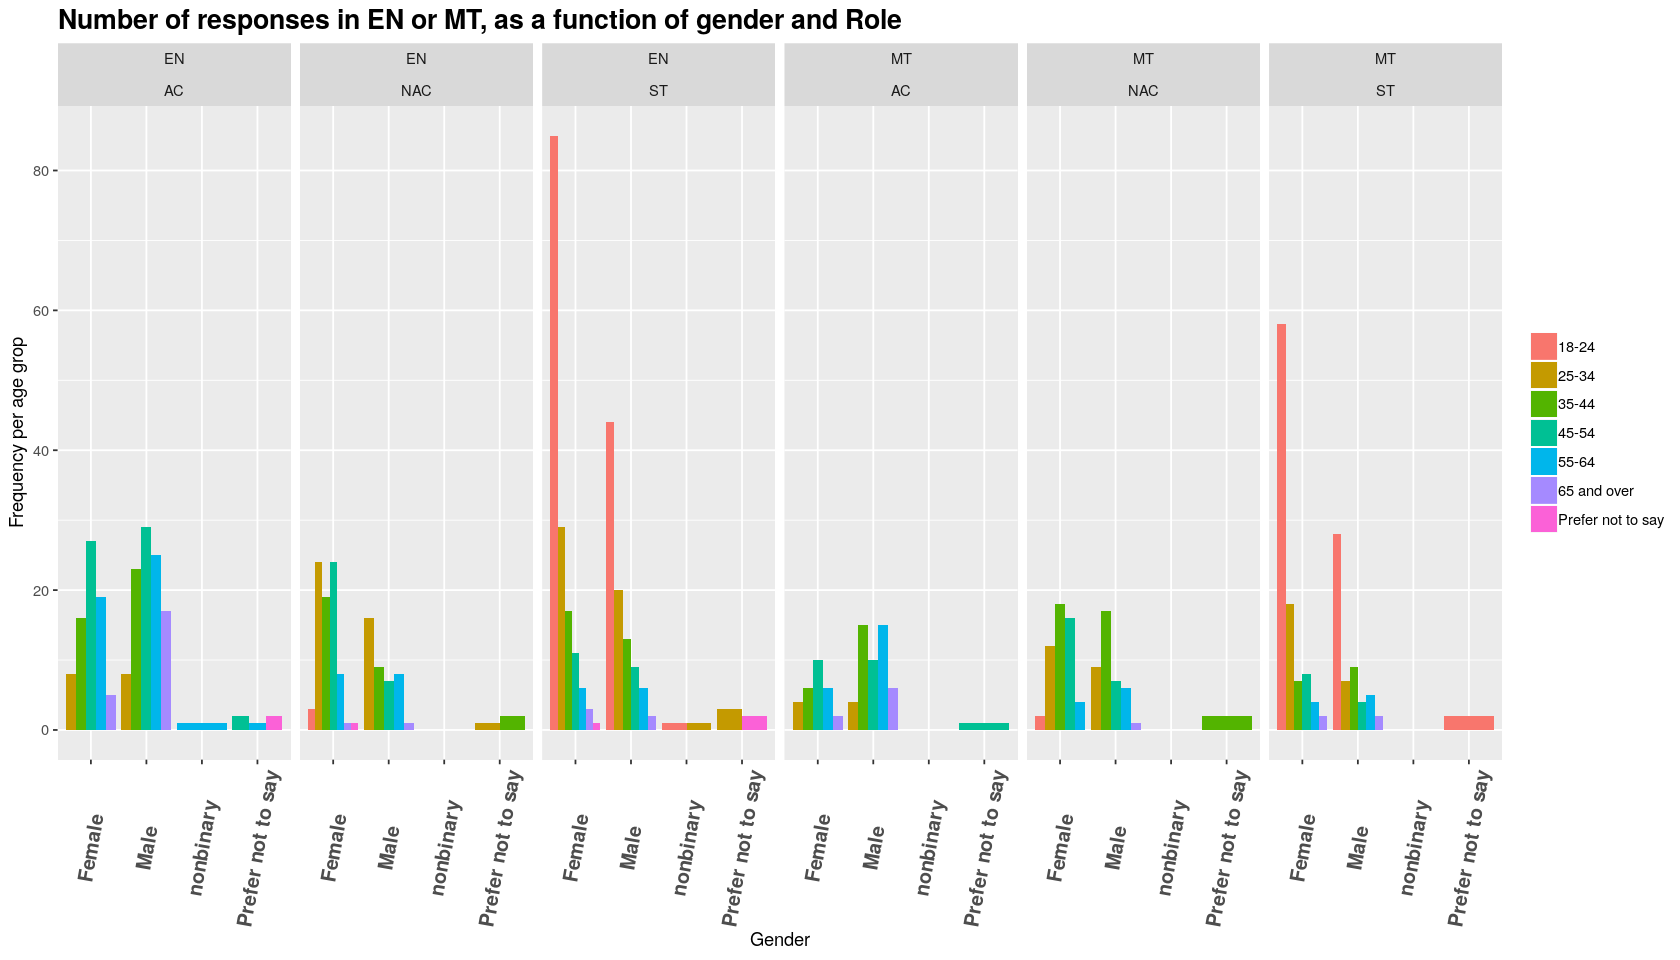

In [53]:
ggplot(gender.age.lang.role, aes(x=Gender, y=NAge, fill=Age)) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(. ~ Lang * Role) + 
    ggtitle("Number of responses in EN or MT, as a function of gender and Role") +
    theme(axis.text.x = element_text(angle=80, vjust=.5, size=12, face='bold')) +
    ylab("Frequency per age grop") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) 

**Who answered from which faculty, and in what language? (Academics and students)**

In [54]:
fics.role.lang <- ddply(subset(common, Role != "NAC"), .(FICS, Role, Lang), 
                        summarize, NFic=length(FICS), NLang=length(Lang))

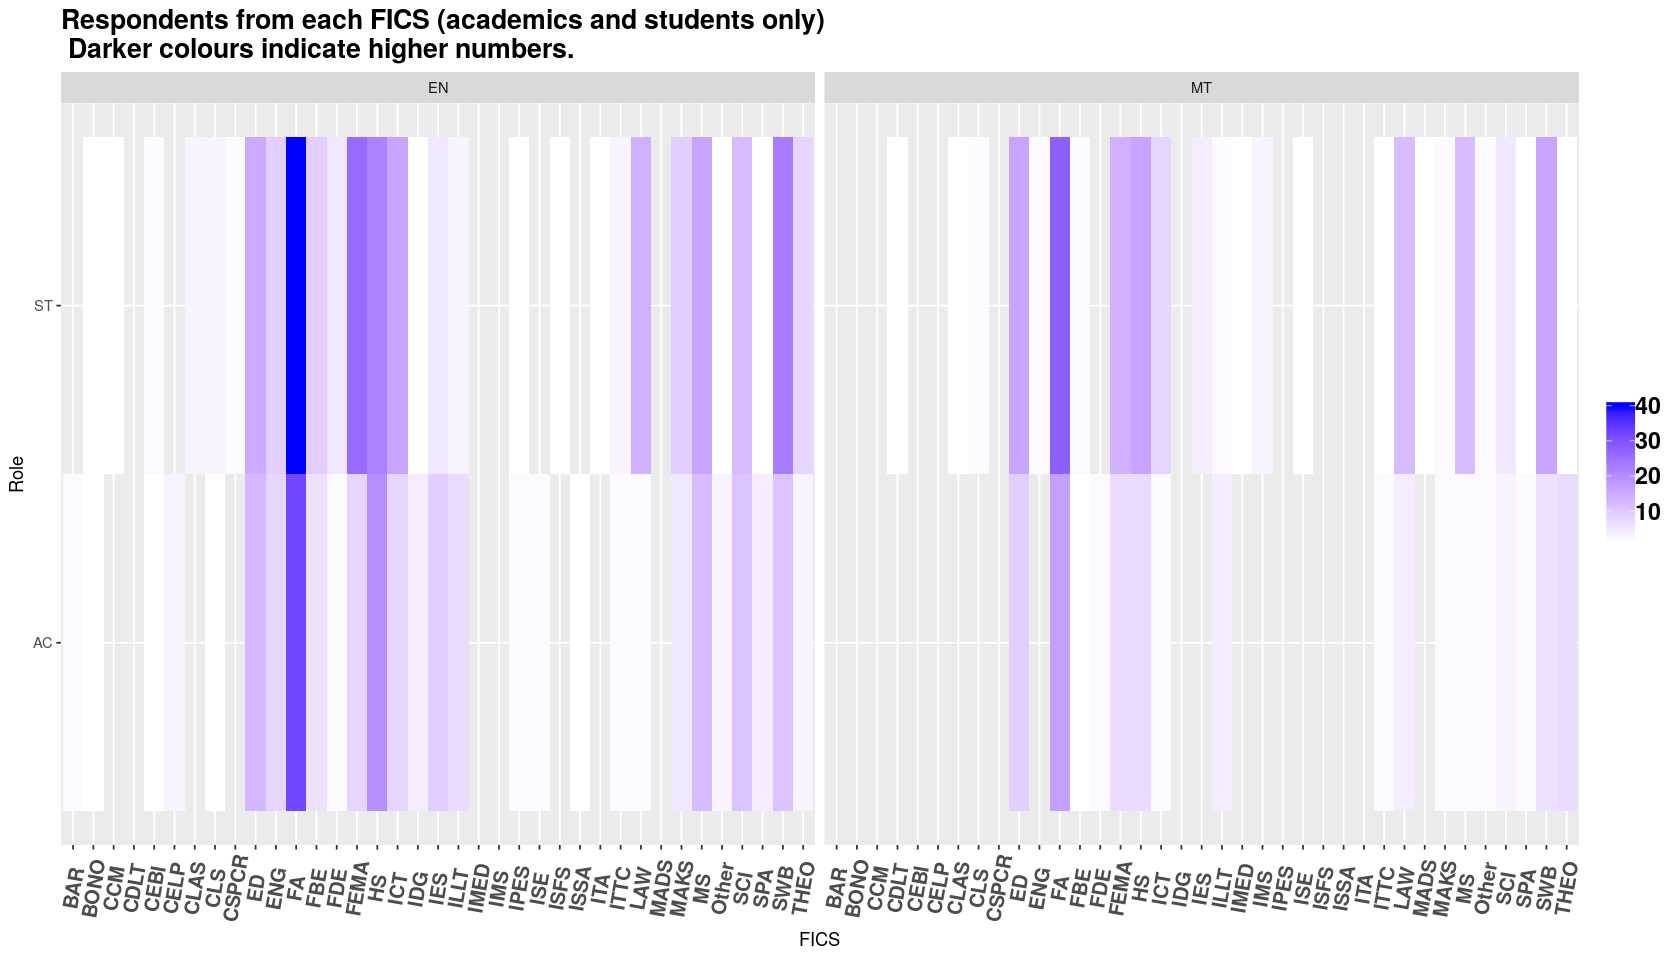

In [55]:
ggplot(fics.role.lang, aes(fill=NFic, x=FICS, y=Role)) +
    geom_tile() + 
    scale_fill_gradient(low="white", high="blue") + 
    ggtitle("Respondents from each FICS (academics and students only) \n Darker colours indicate higher numbers.") + 
    theme(axis.text.x = element_text(angle=80, vjust=.5, size=12, face='bold')) +
    ylab("Role") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=14, face="bold")) + 
    facet_grid(. ~ Lang)


**Among academics/students, how did language questionnaire preference distribute by FICS?**

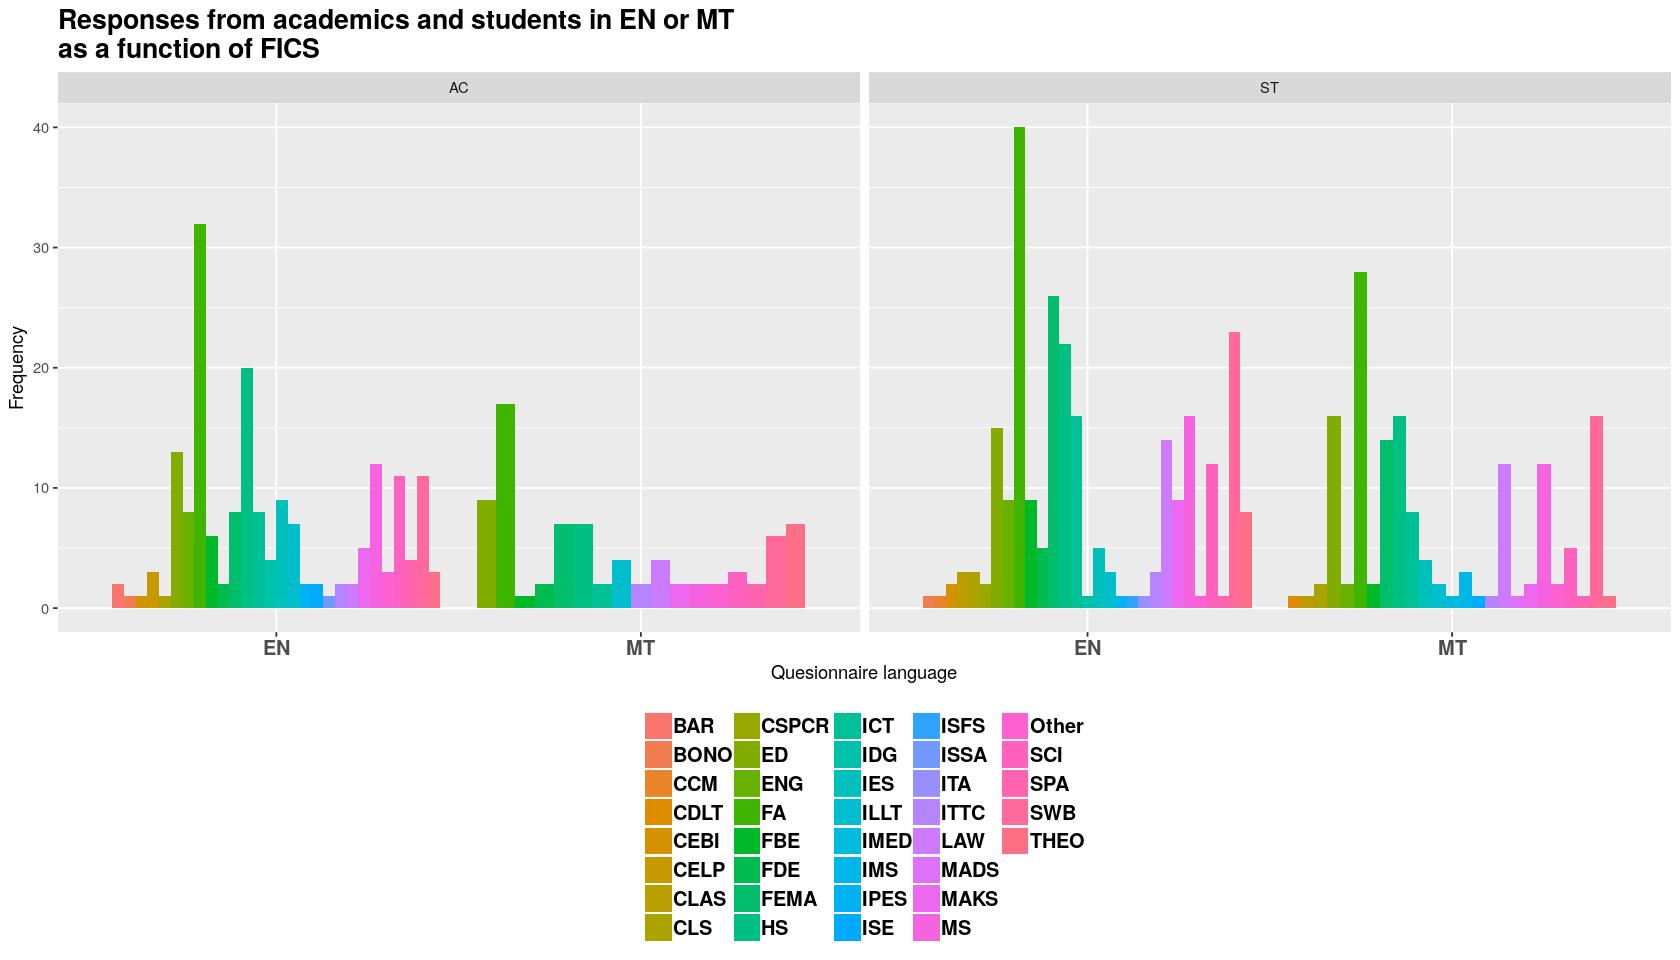

In [56]:
ggplot(fics.role.lang, aes(fill=FICS, x=Lang, y=NLang)) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(. ~ Role) +
    theme(legend.position="bottom") +
    ggtitle("Responses from academics and students in EN or MT\nas a function of FICS") +
    ylab("Frequency") +
    xlab("Quesionnaire language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(size=12, face='bold'))


## 2.2 Language Use

The following focusses on the questions in Section 3 of the questionnaires. For the time being, we only focus on EN and MT.

It's handier to reshape the data into long format, such that we have separate variables for Language and UseContext (family, friends, etc). 

In [21]:
#Pull out the relevant variables first
lang_subset = data.frame(common$ID, common$Role, common$Residence,
                         common$Gender,common$FICS,
                         common$UseFriendsEN, common$UseFriendsMT,
                         common$UseFamilyEN, common$UseFamilyMT,
                         common$UseUniEN, common$UseUniMT,
                        common$UsePrivateEN, common$UsePrivateMT)

In [22]:
#now melt into long format
lang_mlt <- melt(lang_subset)
lang_mlt$Lang = ifelse( grepl('EN$', lang_mlt$variable), 'EN', 'MT' )
lang_mlt$Context = str_match(lang_mlt$variable, "Family|Uni|Friends|Private" )

Using common.ID, common.Role, common.Residence, common.Gender, common.FICS as id variables



In [23]:
lang_mlt <- rename(lang_mlt, c("common.ID" = "ID", "common.Role" = "Role", 
                               "common.Residence" = "Residence",
                               "common.Gender" = "Gender", "common.FICS" = "FICS",
                               "value" = "Value"))

In [25]:
lang_mlt$Lang <- as.factor(lang_mlt$Lang)
lang_mlt$Context <- as.factor(lang_mlt$Context)

The function below takes a DF, one or more group variables, and a measure variable and returns a summary (mean, SD and standard err of the mean).

In [74]:
# New version of length which can handle NA's: if na.rm==T, don't count them
length2 <- function (x, na.rm=TRUE) {
    if (na.rm) sum(!is.na(x))
    else       length(x)
}

## Summarizes data.
## Gives count, mean, standard deviation, standard error of the mean
##Modified after the source here: https://www.rdocumentation.org/packages/plyr/versions/1.8.6/topics/ddply
summary <- function(data=NULL, measurevar, groupvars=NULL, na.rm=TRUE,
                      conf.interval=.95, .drop=TRUE) {    

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          Mean = mean   (xx[[col]], na.rm=na.rm),
          SD   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    datac$SE <- datac$SD / sqrt(datac$N)  # Calculate standard error of the mean

      # Rename the "mean" column    
#     datac <- rename(datac, c("Mean" = paste("Mean", measurevar, sep="_"),
#                             "SD" = paste("SD", measurevar, sep="_"),
#                             "N" = paste("N", measurevar, sep="_"),
#                             "SE" = paste("SE", measurevar, sep="_")))

    return(datac)
}

In [58]:
# Summarise the data for Section 3
# We want to split by role (AC, NAC and ST) and compute mean, SD, and standard err, as well as N
lang.use <- summary(lang_mlt, "Value", groupvars=c("Role", "Context", "Lang"))

**In an average week, what percentage of the time do participants use EN and MT in different contexts?**

The plot below shows mean self-reported time, as a function of role (non-/academic or student). Observe that all self-reports suggest a higher proportion of time spent using MT than EN, *with the exception of University for students and academics, but not non-academics.* 

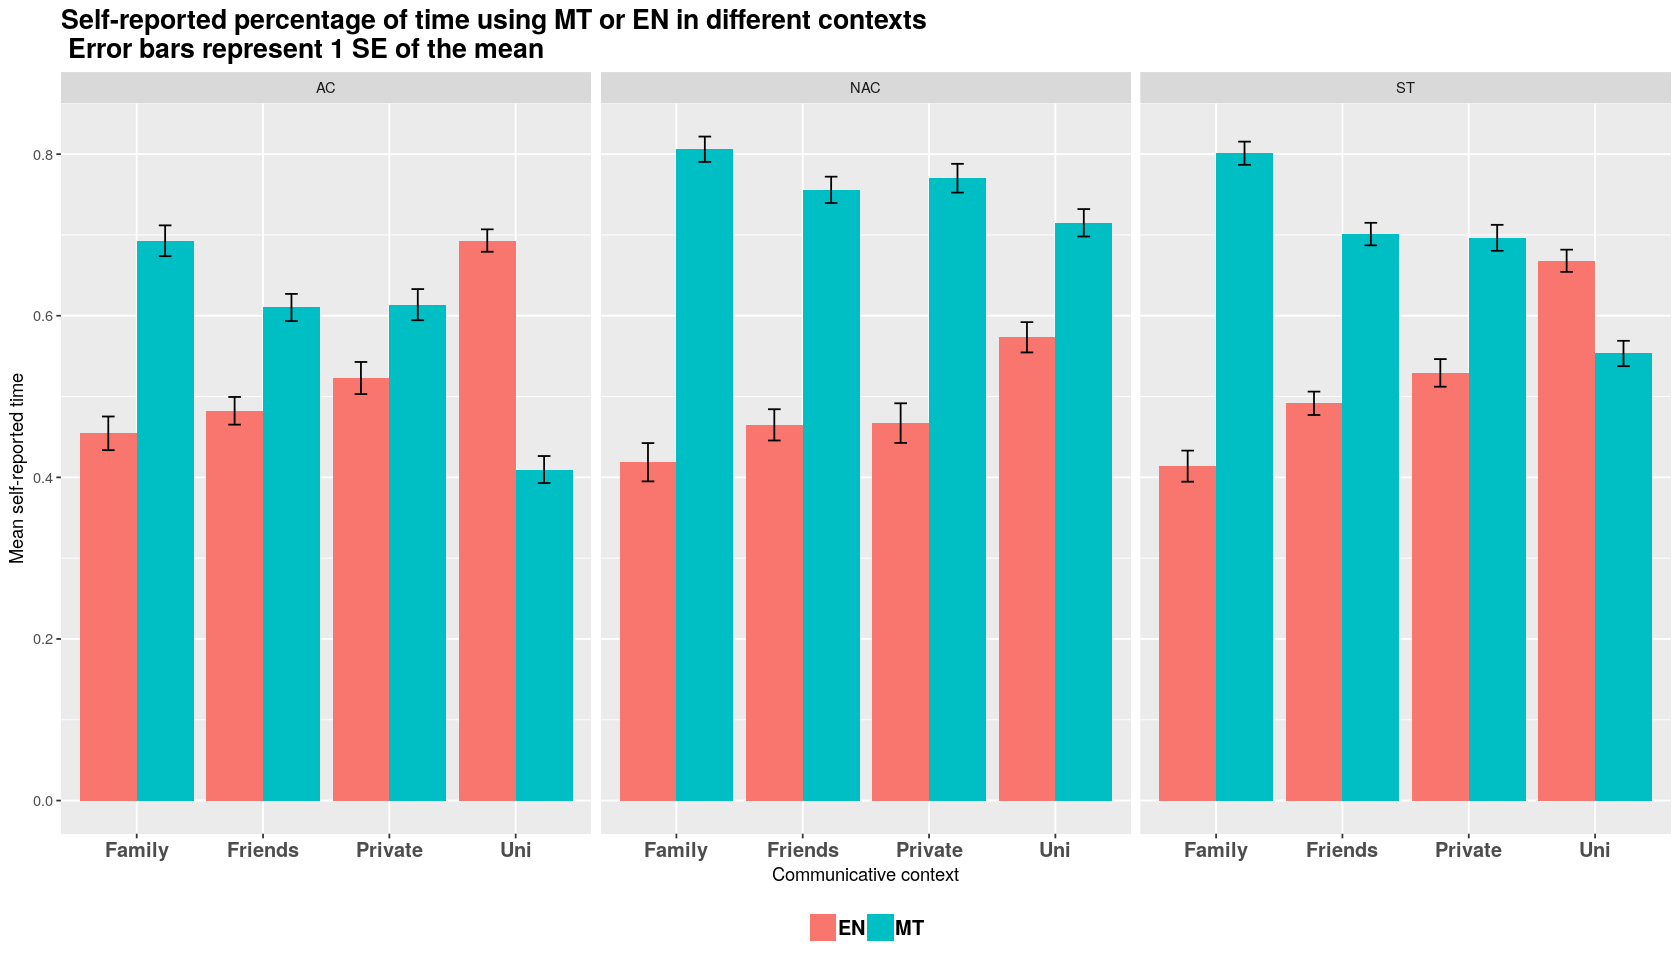

In [59]:
ggplot(lang.use, aes(fill=Lang, x=Context, y=Mean)) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(. ~ Role) +
    theme(legend.position="bottom") +
    ggtitle("Self-reported percentage of time using MT or EN in different contexts \n Error bars represent 1 SE of the mean") +
    ylab("Mean self-reported time") +
    xlab("Communicative context") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(size=12, face='bold')) +
    geom_errorbar(aes(ymin=Mean-SE, ymax=Mean+SE),
                  width=.2,                    # Width of the error bars
                  position=position_dodge(.9))

**Does Context (family, friends, uni, private) exercise a significant effect in self-reported language use, and does this interact with participant Role as academic/student or non-academic?**

Below are the results of an ANOVA taking Value (= self-reported proportion of time spent using a language) as dependent variable, and looking at the impact of Role, Language and Context.

Note that we only use complete cases for this (i.e. cases where we don't have any missing values for any of the self-reports)

**NB** In the analysis below, we are making the simplifying assumption that these are "real" proportions. In fact, participants were given values to select (and no zero value). However, since the scale was clearly a percentage scale, it seems safe to assume that it was interpreted numerically by respondents. On the other hand, we do not assume that no response implies 0% (participants might have chosen not to respond for other reasons).

In [27]:
#Check how many observations we had before and after
nrow(lang_mlt)
lang.mlt.complete <- lang_mlt[complete.cases(lang_mlt),]
nrow(lang.mlt.complete)

[1] 7096

[1] 6038

In [49]:
lang.use.aov <- aov(Value~(Role*Lang*Context), data=lang.mlt.complete)

In [50]:
summary(lang.use.aov)

                    Df Sum Sq Mean Sq F value   Pr(>F)    
Role                 2    3.9    1.97  25.523 9.17e-12 ***
Lang                 1   33.7   33.70 437.405  < 2e-16 ***
Context              3    0.6    0.20   2.541   0.0546 .  
Role:Lang            2   10.9    5.45  70.779  < 2e-16 ***
Role:Context         6    0.2    0.03   0.432   0.8579    
Lang:Context         3   38.8   12.93 167.764  < 2e-16 ***
Role:Lang:Context    6    3.2    0.53   6.817 3.20e-07 ***
Residuals         6014  463.3    0.08                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

The ANOVA suggests that the (self-reported) proportion of time people spend using a language is strongly dependent on:

1. Whether the language is MT or EN (i.e. there is a significant difference in self-reported use of EN vs MT)
2. The effect of language used is moderated by both Role (as shown in the graph, Academics and Students differ from non-academics in their self-reported use) and by Context (whether one is speaking to friends, at uni etc)
    

## 2.3 Language proficiency

In this section, we look at self-reported results on language proficiency in Maltese, English. 

First, some preprocessing as before

In [147]:
#Pull out the relevant variables first
proficiency_subset = data.frame(common$ID, common$Role, common$Residence,
                                common$Gender,common$FICS,
                                common$SpeakEN, common$SpeakMT,
                                common$UnderstandEN, common$UnderstandMT,
                                common$ReadEN, common$ReadMT,
                                common$WriteEN, common$WriteMT,                                
                               )

#now melt into long format
profic_mlt <- melt(proficiency_subset)
profic_mlt$Lang = ifelse( grepl('EN$', profic_mlt$variable), 'EN', 'MT' )
profic_mlt$Skill = str_match(profic_mlt$variable, "Speak|Read|Write|Understand" )

profic_mlt <- rename(profic_mlt, c("common.ID" = "ID", "common.Role" = "Role", 
                               "common.Residence" = "Residence",
                               "common.Gender" = "Gender", "common.FICS" = "FICS",
                               "value" = "Value"))

profic_mlt$Lang <- as.factor(profic_mlt$Lang)
profic_mlt$Skill <- as.factor(profic_mlt$Skill)

Using common.ID, common.Role, common.Residence, common.Gender, common.FICS as id variables



Since the values here are from an ordinal scale, we'll create a version of the Value variable whcih is a factor. We only keep non-missing cases.

In [148]:
profic_mlt$Value.F <- as.factor(profic_mlt$Value)

This time, it's easier to summarise using a frequency table (can compute proportions).

In [149]:
totals <- prop.table(ftable(table(profic_mlt$Role, profic_mlt$Lang, profic_mlt$Skill, profic_mlt$Value.F), margins=2), 1)
proficiency <- data.frame(totals)
names(proficiency) <- c("Role", "Lang", "Skill", "Value", "Prop")

**What is respondents' self-reported proficiency in English or Maltese?**

Below we show the frequency with which they ranked themselves on each scale element (from 1 to 5), as a function of their Role and the Language spoken. Panels are by Role and Language.

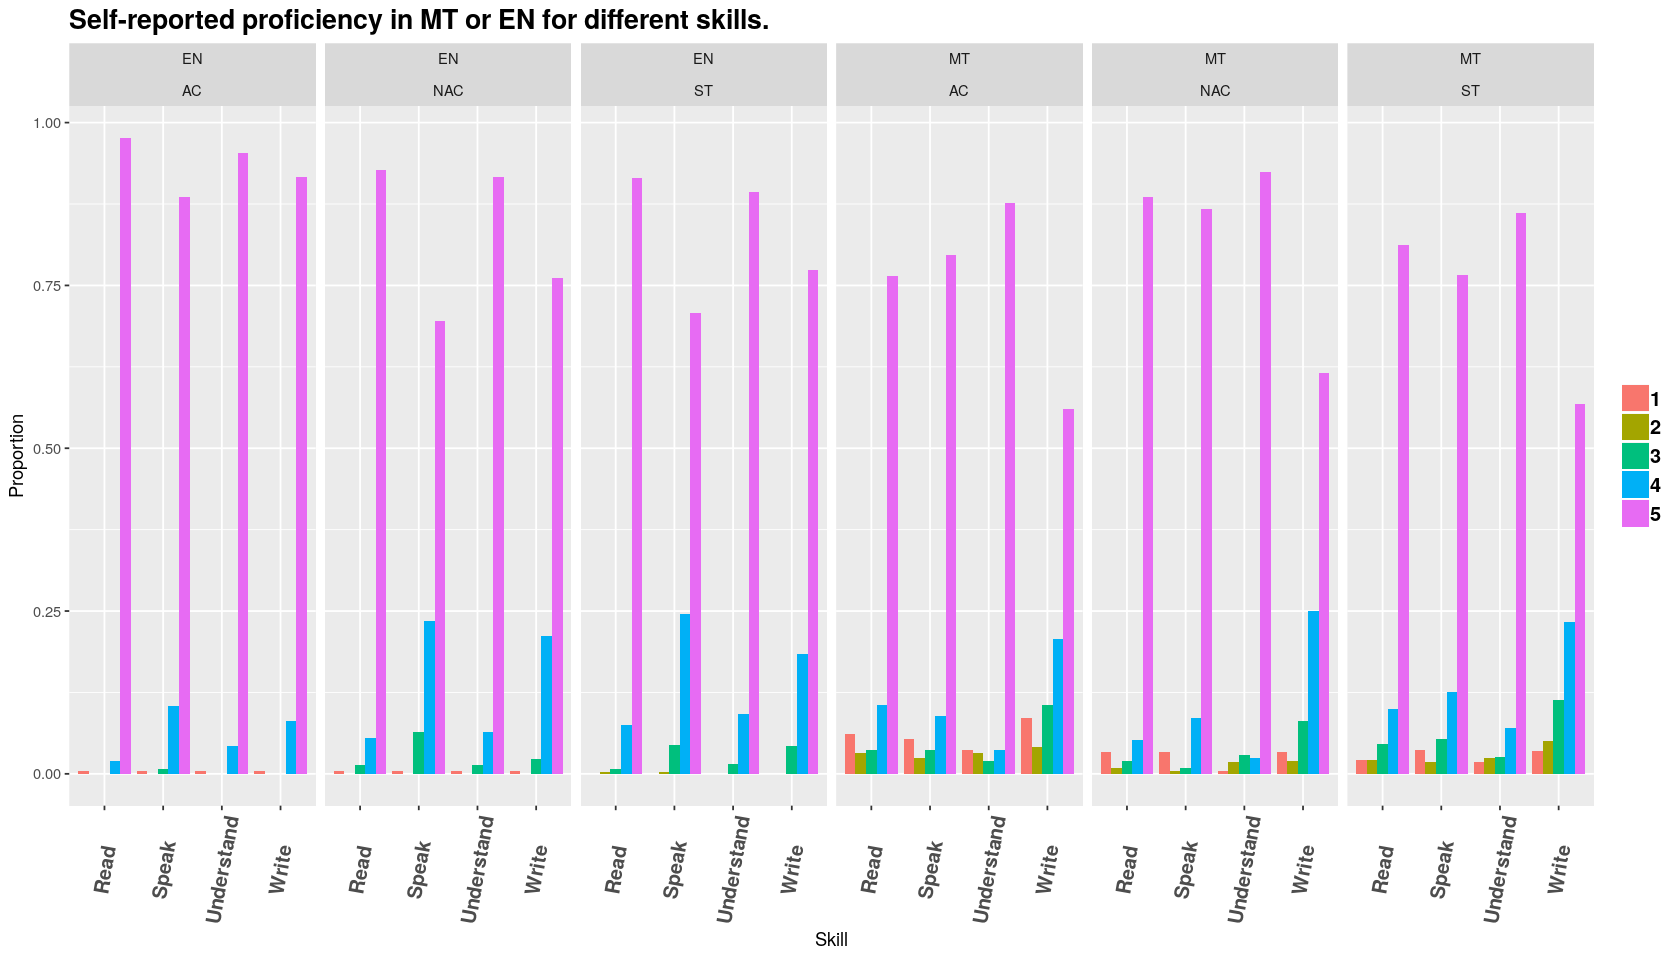

In [150]:
ggplot(proficiency, aes(fill=Value, x=Skill, y=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    facet_grid(. ~ Lang * Role) +
#     theme(legend.position="bottom") +
    ggtitle("Self-reported proficiency in MT or EN for different skills.") +
    ylab("Proportion") +
    xlab("Skill") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(angle=80, vjust=.5, size=12, face='bold')) 

**Does self-reported proficiency differ depending on Role and Skill?**

We'll run an ANOVA as before, this time looking at self-reported proficiency as a function of Role in the two languages. We'll do this for each Skill separately.

**NB** Strictly speaking, likert-type scales like this one aren't parametric, but studies have shown parametric tests can be used reasonably safely.

In [200]:
#As usual, only consider non-NA cases
profic_mlt.complete <- profic_mlt[complete.cases(profic_mlt),]

skills <- c("Read", "Speak", "Understand", "Write")

#Store ANOVA results in a DF
results <- data.frame("Skill" = character(), 
                      "Role"=double(), 
                      "Lang"=double(), 
                      "Role:Lang"=double(), 
                      stringsAsFactors=FALSE)


get_f <- function(an, r) {
    f_score = toString(round(an[r,]$F, 2))
    f = ""
    
    if (an[r,]$P < 0.05) paste(f_score, "*", sep="")
    else f_score    
}

for (s in skills) {
    an <- anova(lm(Value~(Role*Lang), data=profic_mlt.complete[profic_mlt.complete$Skill==s,]))
    results[nrow(results)+1,] <- c(s, get_f(an,1), get_f(an,2), get_f(an,3))
}

results

,Skill,Role,Lang,Role.Lang
,<chr>,<chr>,<chr>,<chr>
1,Read,1.92,74.19*,6.8*
2,Speak,3.12*,7.17*,8.96*
3,Understand,1.33,26.46*,3.2*
4,Write,0.73,168.49*,8.59*


As the above shows, for all four skills, the self-reported proficiency differs significantly. A main effect of role is only observed for Speaking. Role interacts significantly with Language.

## 2.4 Self-appraisal when using different languages

In this section, we consider the questions related to how participants feel when they use Maltese or English, and how they identify culturally.

**Which language are respondents most comfortable using?**

First, we consider responses to the question "I feel like myself when I speak..." in relation to Maltese and English. The table and chart below show the proportion of responses for each item on the ordinal scale from 1 to 5, for this question in relation to MT and EN.

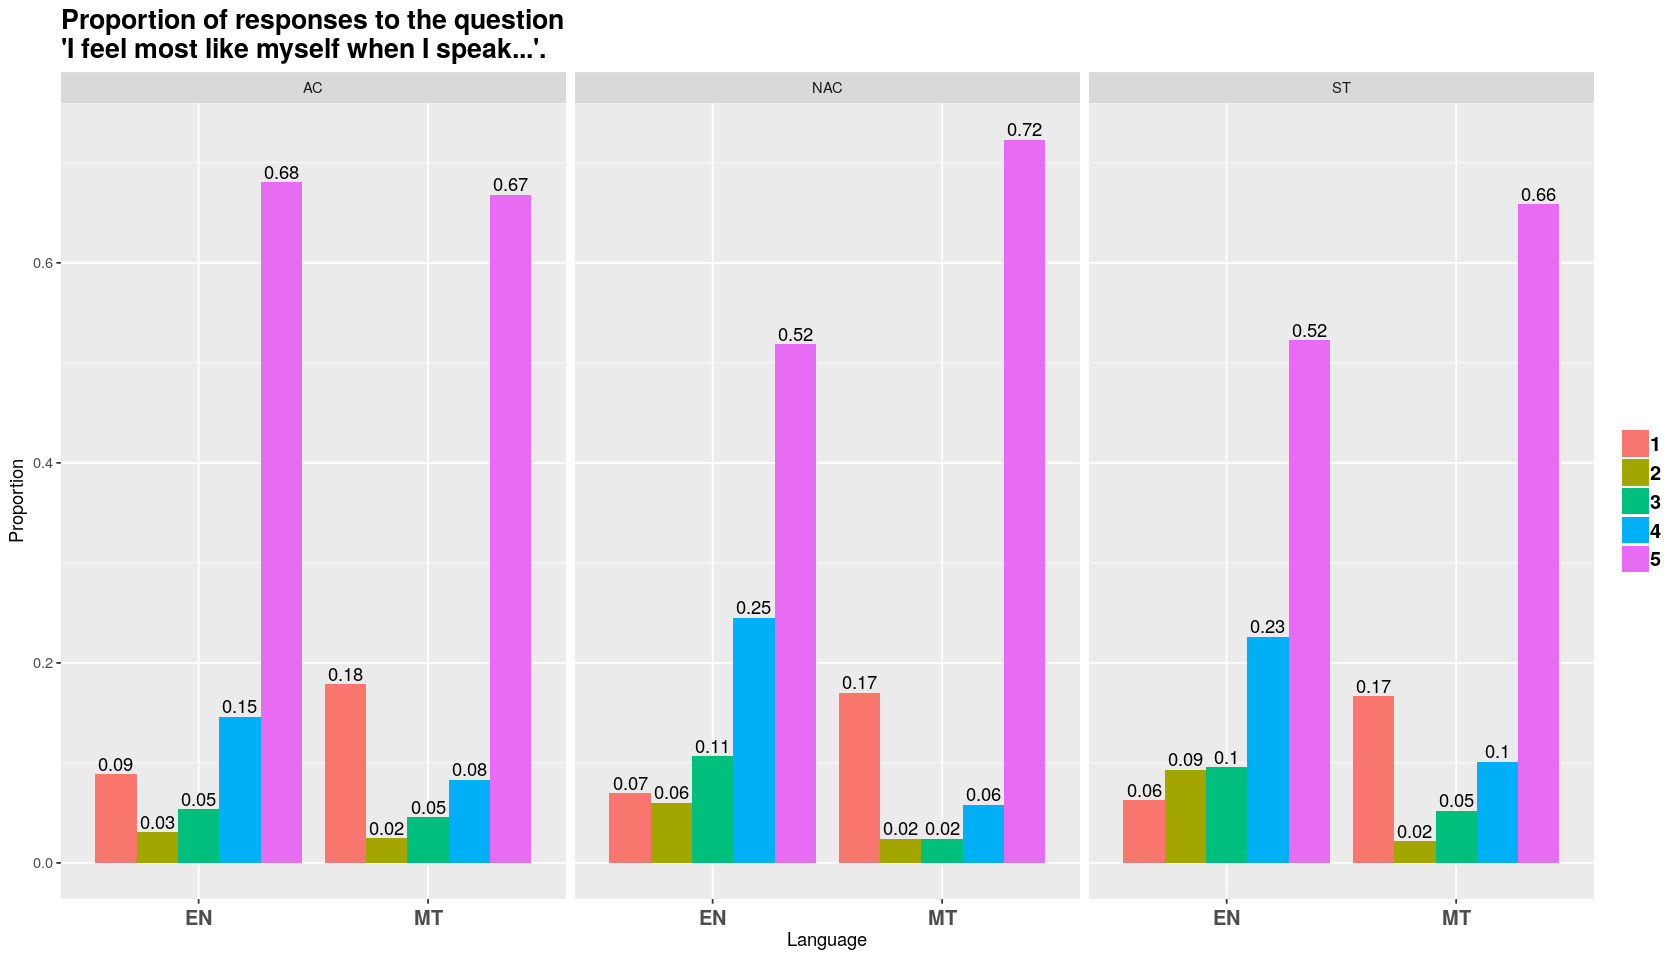

In [218]:
comf.mt <- data.frame(prop.table(table(common$Role, common$ComfortMT), 1))
comf.mt$Lang <- "MT"
comf.en <- data.frame(prop.table(table(common$Role, common$ComfortEN), 1))
comf.en$Lang <- "EN"

comf <- rbind(comf.mt, comf.en);
names(comf) <- c("Role", "Response", "Prop", "Lang")

ggplot(comf, aes(fill=Response, x=Lang, y=Prop, label=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25) +
    facet_grid(. ~ Role) +
    ggtitle("Proportion of responses to the question\n'I feel most like myself when I speak...'.") +
    ylab("Proportion") +
    xlab("Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) 

The most striking trend in the above is that among academics, there is a roughly equal proportion of 5-responses; among non-academics and students, the proportions suggest greater ease when speaking Maltese. This difference is more pronounced for non-academics.

**Which linguistic culture do respondents identify with?**

Next, we consider responses to the question "I identify with a culture that is..." in relation to Maltese and English. The table and chart below show the proportion of responses for each item on the ordinal scale from 1 to 5, for this question in relation to MT and EN.

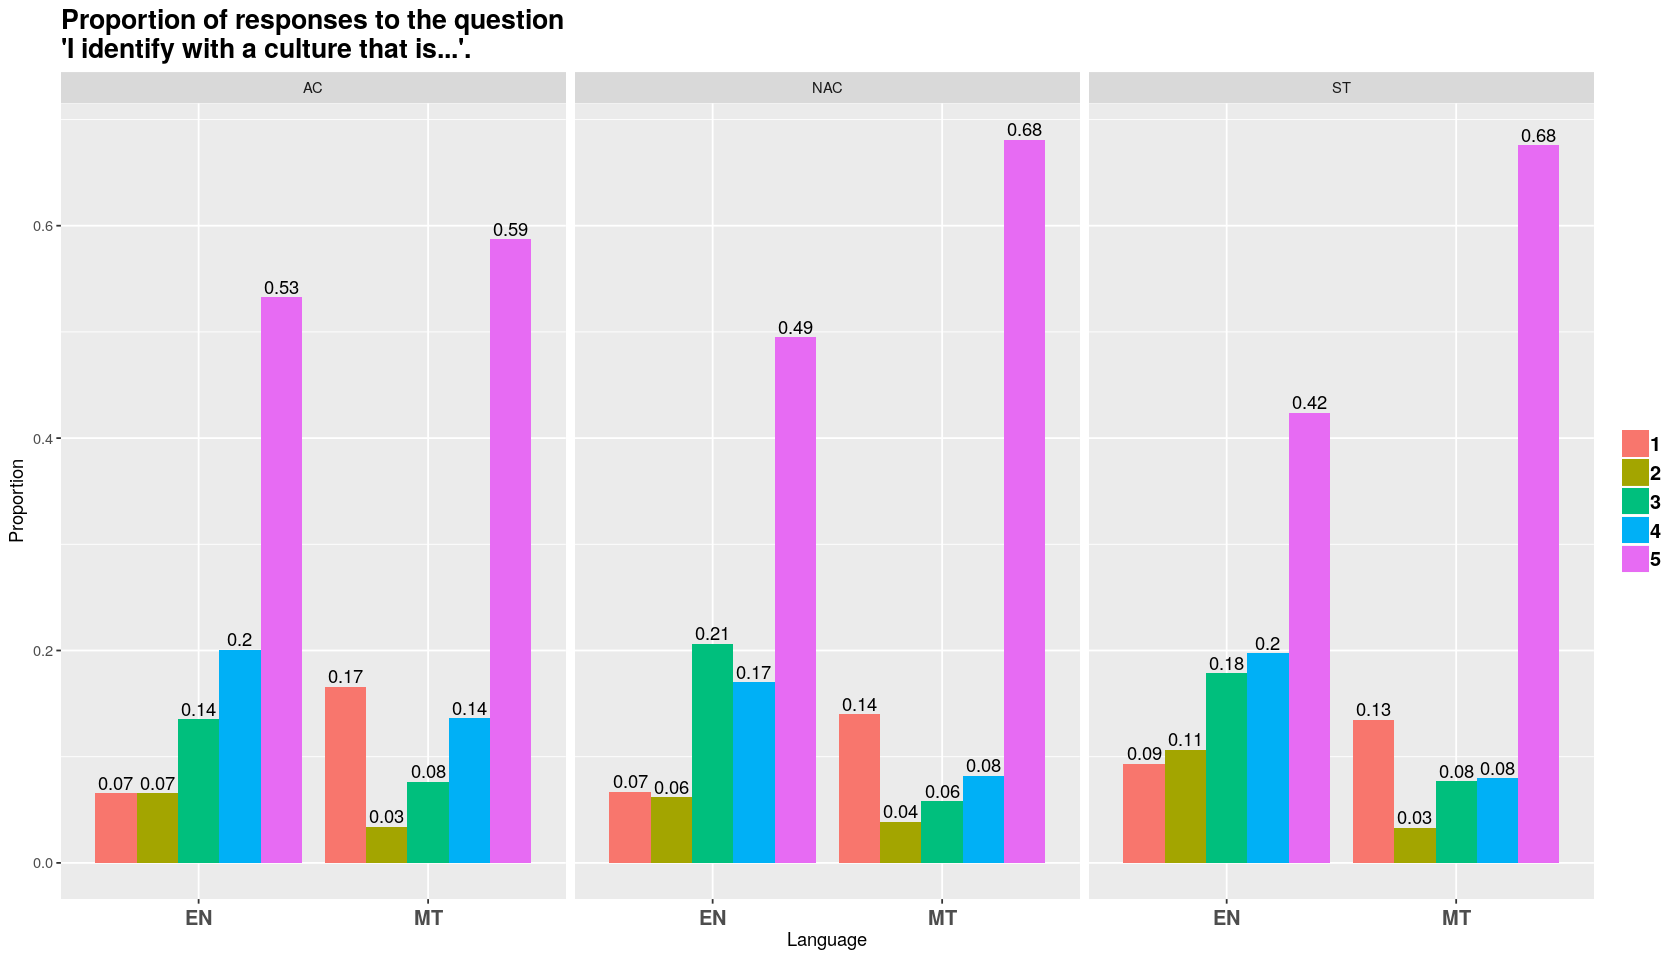

In [226]:
cult.mt <- data.frame(prop.table(table(common$Role, common$CultureMT), 1))
cult.mt$Lang <- "MT"
cult.en <- data.frame(prop.table(table(common$Role, common$CultureEN), 1))
cult.en$Lang <- "EN"

cult <- rbind(cult.mt, cult.en);
names(cult) <- c("Role", "Response", "Prop", "Lang")

ggplot(cult, aes(fill=Response, x=Lang, y=Prop, label=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25) +
    facet_grid(. ~ Role) +
    ggtitle("Proportion of responses to the question\n'I identify with a culture that is...'.") +
    ylab("Proportion") +
    xlab("Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) 

This time, the trend in favour of maximal identification with a Maltese-speaking culture is also evident among academics; however, the difference between EN and MT is once again more pronounced for non-academics and students.

An intersting question is whether the question of cultural identification and the extent to which one is comfortable speaking a language are correlated (this is what one would expect). Below is the outcome of a Spearman correlation by ranks between these two questions, for English and Maltese separately.

In [228]:
cor.test(common$CultureMT,common$ComfortMT, method="spearman")
cor.test(common$CultureEN,common$ComfortEN, method="spearman")

Warning message in cor.test.default(common$CultureMT, common$ComfortMT, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  common$CultureMT and common$ComfortMT
S = 20005000, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7546913 


Warning message in cor.test.default(common$CultureEN, common$ComfortEN, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  common$CultureEN and common$ComfortEN
S = 34738000, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6078022 


In both cases, the correlation is of medium to high strength, though stronger for MT.

**How important a goal is proficiency in these languages?**

Next, we consider responses to the question *It is important to me to use (or eventually use) the language below at a high level of proficiency*.

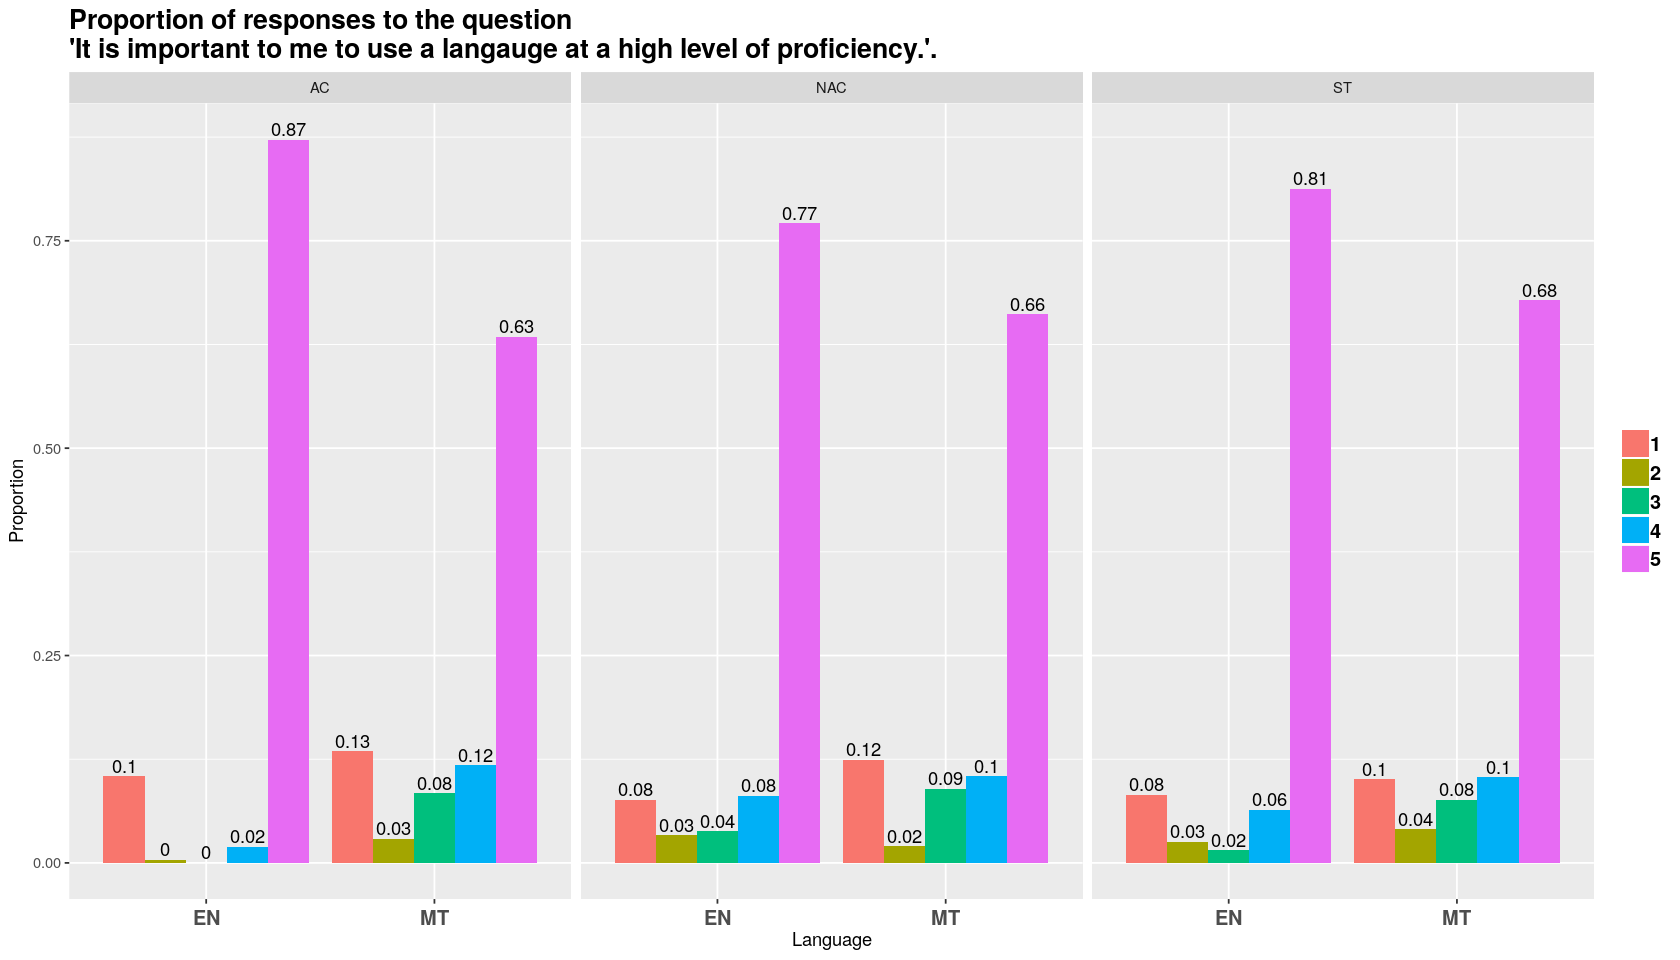

In [229]:
aim.mt <- data.frame(prop.table(table(common$Role, common$ProficiencyAimMT), 1))
aim.mt$Lang <- "MT"
aim.en <- data.frame(prop.table(table(common$Role, common$ProficiencyAimEN), 1))
aim.en$Lang <- "EN"

aim <- rbind(aim.mt, aim.en);
names(aim) <- c("Role", "Response", "Prop", "Lang")

ggplot(aim, aes(fill=Response, x=Lang, y=Prop, label=Prop)) +
    geom_bar(position="dodge", stat="identity") +
    geom_text(aes(label=round(Prop,2)), position=position_dodge(width=0.9), vjust=-0.25) +
    facet_grid(. ~ Role) +
    ggtitle("Proportion of responses to the question\n
            'It is important to me to use a langauge at a high level of proficiency.'.") +
    ylab("Proportion") +
    xlab("Language") +
    theme(plot.title = element_text(size=16, face="bold")) +
    theme(legend.title=element_blank()) +
    theme(legend.text = element_text(size=12, face="bold")) +
    theme(axis.text.x = element_text(vjust=.5, size=12, face='bold')) 

In this case, we observe a shift in the trends observed above. For most of these participants (but particularly for academics and students), a high proficiency in EN is perceived as crucial.